<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/z%2022nd%20may%20Final%20Template%20For%20Regression%20Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold
from sklearn.multioutput import RegressorChain

import requests
import time
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [3]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [4]:
drop_cols = ["Moons", "id"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [5]:
test.shape, train.shape

((4423, 20), (6524, 20))

In [7]:
# feat= [f for f in train.columns if "Feature" in f]
# print(feat)

['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_19', 'Feature_20', 'Feature_21']


In [6]:
def add_features(df):
    cols = [f for f in df.columns if "Feature" in f]
    for f in cols:
        df['pos_'+str(f)] = df[f]+abs(df[f].min())+1
    for f in [f for f in df.columns if "pos" in f]:
        df['log_'+str(f[4:])] = np.log(df[str(f)])
    for f in [f for f in df.columns if "pos" in f]:
        df['sqrt_'+str(f[4:])] = np.sqrt(df[str(f)])
    df.drop(columns = [f for f in df.columns if "pos" in f], inplace=True)
    return df

In [7]:
train = add_features(train)
test = add_features(test)

In [ ]:
ocorr = (train.corrwith(target.target_r).abs() + train.corrwith(target.target_g).abs() + train.corrwith(target.target_b).abs() )/3
ocorr.sort_values(ascending=False)

In [10]:
kf = KFold(n_splits=3, random_state=60)

def validate(X, y, cv, model_name, actual_test):
    oof_pred_r = np.zeros(len(X))
    oof_pred_g = np.zeros(len(X))
    oof_pred_b = np.zeros(len(X))

    original_test_preds = np.zeros((len(actual_test), 3))
    cnt = 1
    scores_dict = {"fold":[],"score_r":[],"score_g":[], "score_b":[]}

    for tr_ind , val_ind in cv.split(X, y):
        # print(f'Fold:{cnt}, Train set: {len(tr_ind)}, Test set:{len(val_ind)}') 
        
        X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
        y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]
    
        
        model_name.fit(X_train,y_train)
        val_pred = pd.DataFrame(model_name.predict(X_val), columns=target.columns)

        score_r = stats.spearmanr(y_val.target_r, val_pred.target_r)[0]
        score_g = stats.spearmanr(y_val.target_g, val_pred.target_g)[0]    
        score_b = stats.spearmanr(y_val.target_b, val_pred.target_b)[0]
        # print(score_r, score_g, score_b)
        scores_dict['fold'].append(cnt)    
        scores_dict['score_r'].append(score_r)
        scores_dict['score_g'].append(score_g)
        scores_dict['score_b'].append(score_b)
        
        oof_pred_r[val_ind] = val_pred.target_r.values
        oof_pred_g[val_ind] = val_pred.target_g.values
        oof_pred_b[val_ind] = val_pred.target_b.values

        original_test_preds += model_name.predict(actual_test)
        
        cnt += 1
    oof_pred_df = pd.concat([pd.DataFrame(oof_pred_r, columns=['target_r']),
                    pd.DataFrame(oof_pred_g, columns=['target_g']),
                    pd.DataFrame(oof_pred_b, columns=['target_b'])], axis=1)

    # print("Final OOF SCORE :", stats.spearmanr(oof_pred_r, target.target_r)[0])
    # print("Final OOF SCORE :",stats.spearmanr(oof_pred_g, target.target_g)[0])
    # print("Final OOF SCORE :",stats.spearmanr(oof_pred_b, target.target_b)[0])

    original_test_preds = original_test_preds / kf.n_splits
    original_test_preds_df = pd.DataFrame(original_test_preds, columns=target.columns)
    return pd.DataFrame(scores_dict), oof_pred_df, original_test_preds_df

# validation_scores, oof_predictions = validate(train[feat], target, kf, RegressorChain(sklearn.ensemble.RandomForestRegressor(random_state=60, n_jobs=-1)))

In [11]:
regressors = [  
                ('BayesianRidge', sklearn.linear_model.BayesianRidge()),
                ('HuberRegressor', sklearn.linear_model.HuberRegressor()),
                ('Lars', sklearn.linear_model.Lars()),
                ('LassoLarsIC', sklearn.linear_model.LassoLarsIC(criterion='aic', fit_intercept=True)),
                ('LinearRegression', sklearn.linear_model.LinearRegression()),
                ('Ridge', sklearn.linear_model.Ridge()),
                ('SGDRegressor', sklearn.linear_model.SGDRegressor(fit_intercept=True)),
                ('TransformedTargetRegressor',sklearn.compose.TransformedTargetRegressor()),
                
                ('AdaBoostRegressor', sklearn.ensemble.AdaBoostRegressor()),
                ('BaggingRegressor', sklearn.ensemble.BaggingRegressor()),
                
                ('DecisionTreeRegressor', sklearn.tree.DecisionTreeRegressor()),
                ('ElasticNet', sklearn.linear_model.ElasticNet()),
                ('ExtraTreeRegressor', sklearn.tree.ExtraTreeRegressor()),
                ('ExtraTreesRegressor', sklearn.ensemble.ExtraTreesRegressor()),
                ('GradientBoostingRegressor', sklearn.ensemble.GradientBoostingRegressor()),
                ('HistGradientBoostingRegressor',sklearn.ensemble.HistGradientBoostingRegressor()),
                
                ('Lasso', sklearn.linear_model.Lasso()),
                ('LassoLars', sklearn.linear_model.LassoLars()),
                
                ('OrthogonalMatchingPursuit',sklearn.linear_model.OrthogonalMatchingPursuit()),
                ('PassiveAggressiveRegressor',sklearn.linear_model.PassiveAggressiveRegressor()),
                ('RANSACRegressor', sklearn.linear_model.RANSACRegressor()),
                ('RandomForestRegressor', sklearn.ensemble.RandomForestRegressor()),
                
                ("XGBRegressor", xgb.XGBRegressor(objective='reg:squarederror')),
                ("LGBMRegressor", lgb.LGBMRegressor())
                ]


In [12]:
names = []
score_r = []
score_g = []
score_b = []
test_preds_model_name= []

for i, (name, model) in enumerate(regressors):
    print(i+1, name)
    if 'random_state' in model.get_params().keys():
        model.set_params(random_state=60)
    if 'n_jobs' in model.get_params().keys():
            model.set_params(n_jobs=-1)

    wrapper = RegressorChain(model)

    validation_scores , oof_predictions_df, globals()['test_pred_%s' % name] = validate(train, target, kf, wrapper, test)
    names.append(name)
    test_preds_model_name.append('test_pred_%s' % name)

    score_r.append(stats.spearmanr(oof_predictions_df.target_r, target.target_r)[0])
    score_g.append(stats.spearmanr(oof_predictions_df.target_g, target.target_g)[0])
    score_b.append(stats.spearmanr(oof_predictions_df.target_b, target.target_b)[0])
result_df = pd.concat([pd.Series(names), pd.Series(score_r), pd.Series(score_g), pd.Series(score_b)], axis=1)
result_df.columns = ['model', 'r_score', 'g_score', 'b_score']
result_df['mean_score'] = result_df[['r_score', 'g_score', 'b_score']].mean(axis=1)
result_df.sort_values(by='mean_score', ascending=False)

1 BayesianRidge
2 HuberRegressor
3 Lars
4 LassoLarsIC
5 LinearRegression
6 Ridge
7 SGDRegressor
8 TransformedTargetRegressor
9 AdaBoostRegressor
10 BaggingRegressor
11 DecisionTreeRegressor
12 ElasticNet
13 ExtraTreeRegressor
14 ExtraTreesRegressor
15 GradientBoostingRegressor
16 HistGradientBoostingRegressor
17 Lasso
18 LassoLars
19 OrthogonalMatchingPursuit
20 PassiveAggressiveRegressor
21 RANSACRegressor
22 RandomForestRegressor
23 XGBRegressor
24 LGBMRegressor


,model,r_score,g_score,b_score,mean_score
3,LassoLarsIC,0.000289,0.083898,0.085020,0.056402
6,SGDRegressor,-0.000978,0.075539,0.089838,0.054799
18,OrthogonalMatchingPursuit,-0.004764,0.074930,0.083013,0.051060
0,BayesianRidge,-0.014542,0.075589,0.083471,0.048173
5,Ridge,-0.033415,0.064357,0.076529,0.035824
21,RandomForestRegressor,-0.020684,0.050227,0.065837,0.031793
22,XGBRegressor,-0.030161,0.049301,0.075989,0.031710
13,ExtraTreesRegressor,-0.010315,0.043613,0.061674,0.031658
9,BaggingRegressor,-0.003431,0.058472,0.039012,0.031351
1,HuberRegressor,-0.030966,0.053958,0.067108,0.030034


# OPTIMIZATION 

In [16]:
for i in result_df.sort_values(by='mean_score', ascending=False)['model']:
    print(i)

LassoLarsIC
SGDRegressor
OrthogonalMatchingPursuit
BayesianRidge
Ridge
RandomForestRegressor
XGBRegressor
ExtraTreesRegressor
BaggingRegressor
HuberRegressor
GradientBoostingRegressor
LGBMRegressor
HistGradientBoostingRegressor
TransformedTargetRegressor
LinearRegression
AdaBoostRegressor
DecisionTreeRegressor
PassiveAggressiveRegressor
RANSACRegressor
Lars
ExtraTreeRegressor
ElasticNet
Lasso
LassoLars


In [49]:
def set_params():
    
    return params

In [50]:
import optuna
kf = KFold(n_splits=5, random_state=60)
X = train
y = target

N_TRIALS = 10
def objective_lassolars_ic(trial):    
    params = {
            'criterion' : trial.suggest_categorical('criterion', ['aic', 'bic']),
            'fit_intercept' : trial.suggest_categorical('fit_intercept', ['True', 'Fasle']),

            }
    
    oof_pred_r = np.zeros(len(X))
    oof_pred_g = np.zeros(len(X))
    oof_pred_b = np.zeros(len(X))

    cnt = 1
    for tr_ind , val_ind in kf.split(X, y):
        X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
        y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]


        model = sklearn.linear_model.LassoLarsIC(**params)
        # print(model)
        wrapper = RegressorChain(model)
    
        wrapper.fit(X_train,y_train)
        val_pred = pd.DataFrame(wrapper.predict(X_val), columns=y.columns)
        # print(val_pred)

        score_r = stats.spearmanr(y_val.target_r, val_pred.target_r)[0]
        score_g = stats.spearmanr(y_val.target_g, val_pred.target_g)[0]    
        score_b = stats.spearmanr(y_val.target_b, val_pred.target_b)[0]
        print(score_r, score_g, score_b)
        
        
        oof_pred_r[val_ind] = val_pred.target_r.values
        oof_pred_g[val_ind] = val_pred.target_g.values
        oof_pred_b[val_ind] = val_pred.target_b.values
        print("DONE FOLD :", cnt)
        print("***" * 50)

        cnt += 1
        
    oof_pred_df = pd.concat([pd.DataFrame(oof_pred_r, columns=['target_r']),
                    pd.DataFrame(oof_pred_g, columns=['target_g']),
                    pd.DataFrame(oof_pred_b, columns=['target_b'])], axis=1)
    # display(oof_pred_df)

    score_r = stats.spearmanr(oof_pred_df.target_r, y.target_r)[0]
    score_g = stats.spearmanr(oof_pred_df.target_g, y.target_g)[0]
    score_b = stats.spearmanr(oof_pred_df.target_b, y.target_b)[0]
    score = (score_r+score_g+score_b)/ 3
    print(score)

    from google.colab import output
    output.clear()
    
    return score
 
def optimize():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_lassolars_ic, n_trials=N_TRIALS, show_progress_bar= True)
    display(study.best_params)
    display(study.best_trial.value)
    return study.best_params



In [51]:
lassolars_ic_params = optimize()

[I 2021-05-22 11:34:14,616] A new study created in memory with name: no-name-7da020c4-b54e-4b46-aa84-cfac224c47ef


[W 2021-05-22 11:34:14,652] Trial 0 failed because of the following error: TypeError('objective_lassolars_ic() takes 0 positional arguments but 1 was given')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
TypeError: objective_lassolars_ic() takes 0 positional arguments but 1 was given



TypeError: ignored

In [45]:
lassolars_ic_params

{'criterion': 'aic', 'fit_intercept': 'Fasle'}

# Preds

In [19]:
# print(test_preds_model_name)

['test_pred_BayesianRidge', 'test_pred_HuberRegressor', 'test_pred_Lars', 'test_pred_LassoLarsIC', 'test_pred_LinearRegression', 'test_pred_Ridge', 'test_pred_SGDRegressor', 'test_pred_TransformedTargetRegressor', 'test_pred_AdaBoostRegressor', 'test_pred_BaggingRegressor', 'test_pred_DecisionTreeRegressor', 'test_pred_ElasticNet', 'test_pred_ExtraTreeRegressor', 'test_pred_ExtraTreesRegressor', 'test_pred_GradientBoostingRegressor', 'test_pred_HistGradientBoostingRegressor', 'test_pred_Lasso', 'test_pred_LassoLars', 'test_pred_OrthogonalMatchingPursuit', 'test_pred_PassiveAggressiveRegressor', 'test_pred_RANSACRegressor', 'test_pred_RandomForestRegressor', 'test_pred_XGBRegressor', 'test_pred_LGBMRegressor']


,model,r_score,g_score,b_score,mean_score
3,LassoLarsIC,-0.005832,0.086648,0.086879,0.055898
6,SGDRegressor,-0.017823,0.077560,0.091449,0.050396
2,Lars,-0.019103,0.077005,0.093062,0.050321
0,BayesianRidge,-0.014530,0.077892,0.085976,0.049779
18,OrthogonalMatchingPursuit,-0.004511,0.088286,0.059466,0.047747
5,Ridge,-0.025705,0.073455,0.083952,0.043900
4,LinearRegression,-0.025927,0.073273,0.083738,0.043695
7,TransformedTargetRegressor,-0.025927,0.073273,0.083738,0.043695
1,HuberRegressor,-0.025271,0.066406,0.079016,0.040050
22,XGBRegressor,-0.030161,0.049301,0.075989,0.031710


In [23]:
prediction = test_pred_SGDRegressor + test_pred_HuberRegressor + test_pred_Lars + test_pred_Ridge + test_pred_LassoLarsIC

In [24]:
prediction = prediction / 5

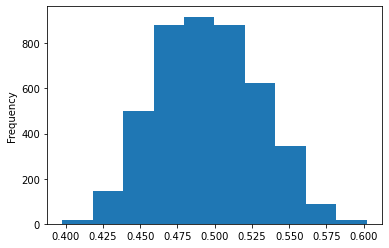

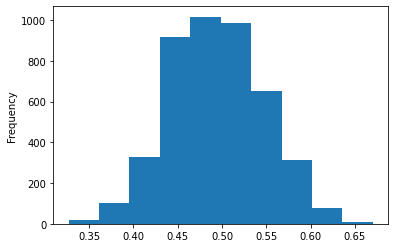

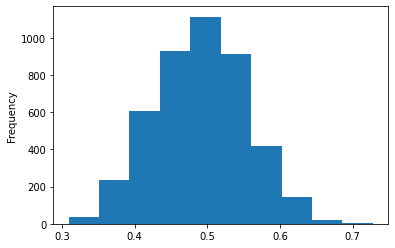

In [25]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [27]:
prediction

,target_r,target_g,target_b
0,0.449834,0.425247,0.433877
1,0.539753,0.586936,0.595939
2,0.529707,0.612011,0.595883
3,0.464585,0.428143,0.429419
4,0.533656,0.502900,0.552891
...,...,...,...
4418,0.472585,0.521672,0.493304
4419,0.497071,0.531760,0.506529
4420,0.487061,0.523665,0.500014
4421,0.475245,0.491682,0.446685


In [ ]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
